In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from numpy import linalg as la

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from gMLV import *
#import importlib
# import gMLV_ML
# import gMLV_sim
#importlib.reload(gMLV_ML);
#importlib.reload(gMLV_sim);

In [2]:
# some plotting functions
def plot_gMLV(yobs, sobs, timepoints):
    fig, axs = plt.subplots(1, 2, layout='constrained')
    axs[0].plot(timepoints, yobs)
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]')
    if sobs.shape[1] > 0:
        axs[1].plot(timepoints, sobs)
        axs[1].set_xlabel('time')
        axs[1].set_ylabel('[metabolite]');

def plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, timepoints):
    # plot the fit
    cols = ["red", "green", "blue", "royalblue","black"]
    fig, axs = plt.subplots(1, 2, layout='constrained')

    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
        axs[0].plot(timepoints, yobs_h[:, species_idx], '--', color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]');

    for metabolite_idx in range(sobs.shape[1]):
        axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].plot(timepoints, sobs_h[:, metabolite_idx], '--', color=cols[metabolite_idx])
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('[metabolite]');

def compare_params(mu_h, mu, M_h, M):
    print("\nINFERRED PARAMS:")
    print("mu_hat/mu:")
    print(np.array(mu_h))
    print(np.array(mu))
    print("\nM_hat/M:")
    print(np.round(np.array(M_h),decimals=2))
    print("\n",np.array(M) )

    # plot the params
    fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(6.4*2,4.8))
    axs[0].stem(np.arange(0,len(mu), dtype="int32"), np.array(mu_h), markerfmt="D")
    axs[0].stem(np.arange(0,len(mu), dtype="int32"), np.array(mu), markerfmt="X")
    axs[0].set_xlabel('i')
    axs[0].set_ylabel('mu[i]');

    axs[1].stem(np.arange(0, M.shape[0] ** 2), np.array(M_h).flatten(), markerfmt="D")
    axs[1].stem(np.arange(0, M.shape[0] ** 2), np.array(M).flatten(), markerfmt="X")
    axs[1].set_ylabel('M[i,j]');
    
def compare_params_p(mu_h, mu, M_h, M, e_h, e):
    print("\ninferred params:")
    print("mu_hat/mu:")
    print(np.array(mu_h))
    print(np.array(mu))
    print("\nM_hat/M:")
    print(np.round(np.array(M_h),decimals=2))
    print("\n",np.array(M) )
    print("e_hat/e:")
    print(np.array(e_h))
    print(np.array(e))

    # plot the params
    plt.figure(figsize=(6.4*3,4.8))
    plt.subplot(1, 3, 1)
    plt.stem(np.arange(0, M.shape[0], dtype="int32"), np.array(mu_h), markerfmt="D")
    plt.stem(np.arange(0, M.shape[0], dtype="int32"), np.array(mu), markerfmt="X")

    plt.subplot(1, 3, 2)
    plt.stem(np.arange(0, M.shape[0] ** 2), np.array(M_h).flatten(), markerfmt="D")
    plt.stem(np.arange(0, M.shape[0] ** 2), np.array(M).flatten(), markerfmt="X")
    
    plt.subplot(1, 3, 3)
    plt.stem(np.arange(0, M.shape[0]), np.array(e_h), markerfmt="D")
    plt.stem(np.arange(0, M.shape[0]), np.array(e), markerfmt="X")
    

## Simulate some time course data and perform ridge regression as in Stein et al. 2013
I have coded up the Stein model and ridge regression without the perturbation term (Ridge1) and with a single perturbation (Ridge 2). <br>
Ridge regression is designed to cause shrinkage to prevent overfitting. It isn't supposed to be used for variable
selection. We should use Lasso for this, however I think we need to constrain parameters.

number of species: 5
specific growth rates: [0.76274785 1.19367005 0.59906632 0.98206338 0.85342842]
interaction matrix: 
[[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
metabolite production: 
None
minimum found: a0/a1/error: 0.026366508987303583 4.281332398719396e-06 0.12734030103579527
unconstrained error        : 0.12970530377533546

INFERRED PARAMS:
mu_hat/mu:
[8.44387268 0.38704093 9.49489231 1.31911717 4.32155615]
[0.76274785 1.19367005 0.59906632 0.98206338 0.85342842]

M_hat/M:
[[-0.72 -0.05 -0.12  0.05 -0.01]
 [ 0.07 -0.12 -0.03  0.06  0.06]
 [-0.87  0.02 -1.37 -0.    1.18]
 [-0.04  0.01 -0.02 -0.02  0.01]
 [-0.18 -0.12  0.61  0.08 -0.94]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]


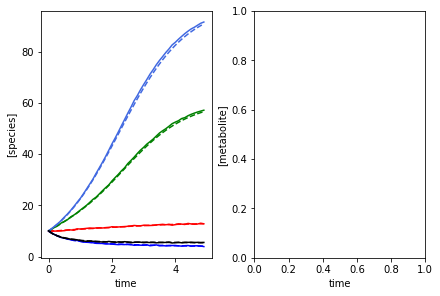

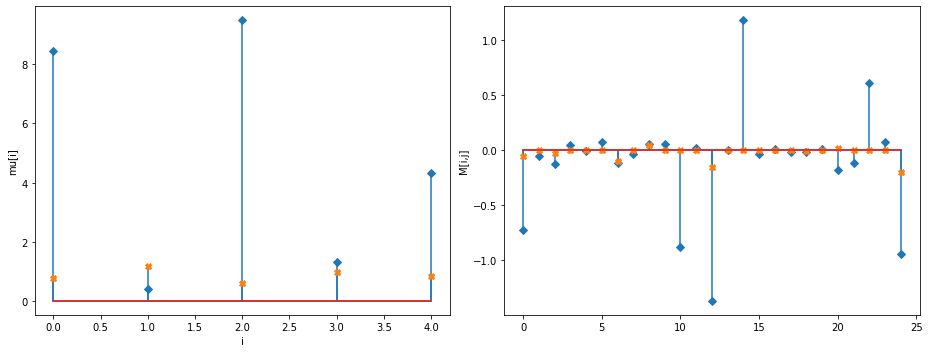

In [3]:
# Five species, single time course. In this example n >> p and it it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable

## SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
# plot_gMLV(yobs, sobs, times)

## PERFORM REGRESSION
# linearise
X, F = linearize_time_course_16S(yobs, times)
# print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, nsp=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0, a1)
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu_h, mu, M_h, M)


number of species: 5
specific growth rates: [1.4823826  1.2534304  0.75914718 0.83666159 2.35638933]
interaction matrix: 
[[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
metabolite production: 
None
X: (12, 6)
F: (12, 5)
n: 60, p: 30
minimum found: a0/a1/error: 5.455594781168514 0.00615848211066026 0.05556490672893963
unconstrained error        : 0.13255342235459489

INFERRED PARAMS:
mu_hat/mu:
[0.58287882 0.64662906 0.00360562 0.67239695 0.28778717]
[1.4823826  1.2534304  0.75914718 0.83666159 2.35638933]

M_hat/M:
[[-0.02 -0.   -0.    0.    0.  ]
 [ 0.   -0.03 -0.01  0.01  0.01]
 [-0.   -0.01 -0.02  0.01 -0.01]
 [-0.    0.   -0.   -0.01  0.  ]
 [ 0.01 -0.   -0.01  0.   -0.02]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.   

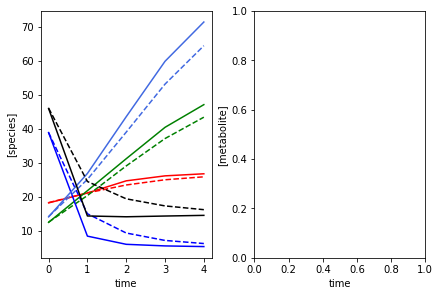

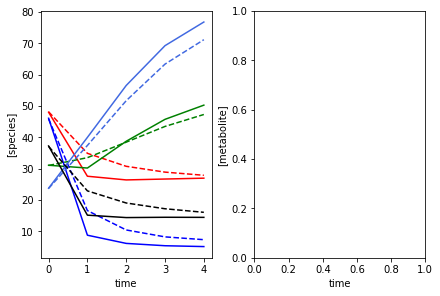

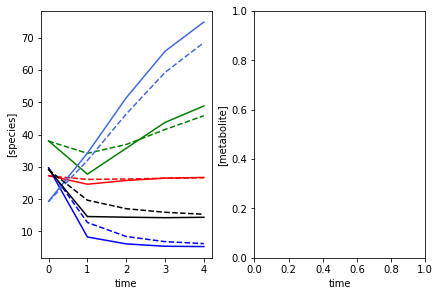

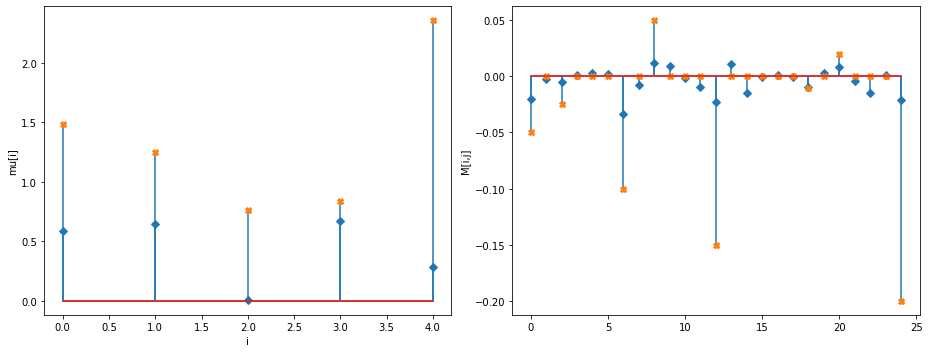

In [4]:
# Five species, lower number of time points, multiple time course
## SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu)
simulator.print()

## PRODUCE SIMULATED RESULTS
# data structures for results
ryobs = []
rsobs = []
ry0 = []
rs0 = []
X = np.array([], dtype=np.double).reshape(0, num_species+1)
F = np.array([], dtype=np.double).reshape(0, num_species)

num_timecourses = 3
times = np.arange(0,5,1)
for timecourse_idx in range(num_timecourses):
    # initial conditions
    init_species = np.random.uniform(low=10, high=50, size=num_species)
    init_metabolites = np.random.uniform(low=10, high=50, size=num_metabolites)

    yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

    # add some gaussian noise
    yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
    sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

    # append results
    ryobs.append(yobs)
    rsobs.append(sobs)
    ry0.append(init_species)
    rs0.append(init_metabolites)
    Xs, Fs = linearize_time_course_16S(yobs,times)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])

print(f"X: {X.shape}")
print(f"F: {F.shape}")
print(f"n: {num_species*F.shape[0]}, p: {num_species + num_species**2}")

## PERFORM REGRESSION
# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, nsp=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0=a0, a1=a1)
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
for timecourse_idx in range(num_timecourses):
    yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((ry0[timecourse_idx], rs0[timecourse_idx])))
    plot_fit_gMLV(ryobs[timecourse_idx], yobs_h, rsobs[timecourse_idx], sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu_h, mu, M_h, M)

## ANALYSE RESULTS
# do some bootstrapping to help with interpretation of parameters
# starred parameters are considered different to zero
do_bootstrapping(X, F, num_species, a0, a1, len(times), nboots=100)

number of species: 5
specific growth rates: [0.58670459 0.39577418 1.79492659 0.99204394 0.90366911]
interaction matrix: 
[[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
metabolite production: 
None
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
n: 245, p: 30
minimum found: a0/a1/a2/error: 0.0774263682681127 0.0001 1e-06 0.12345911315233198
unconstrained error        : 0.12606344126832034

inferred params:
mu_hat/mu:
[0.38072454 0.15994984 7.03899416 1.45595227 5.86750318]
[0.58670459 0.39577418 1.79492659 0.99204394 0.90366911]

M_hat/M:
[[-0.13  0.02  0.05 -0.01  0.01]
 [ 0.03 -0.1   0.    0.05 -0.01]
 [ 0.07 -0.02 -0.57  0.01 -0.16]
 [ 0.01  0.02 -0.01 -0.02 -0.06]
 [ 0.13  0.03 -0.35 -0.02 -0.49]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.

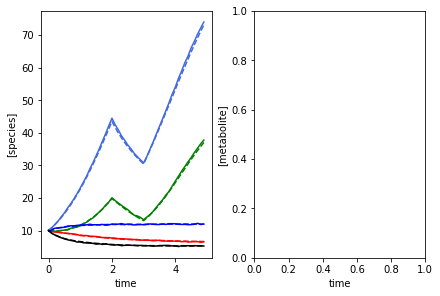

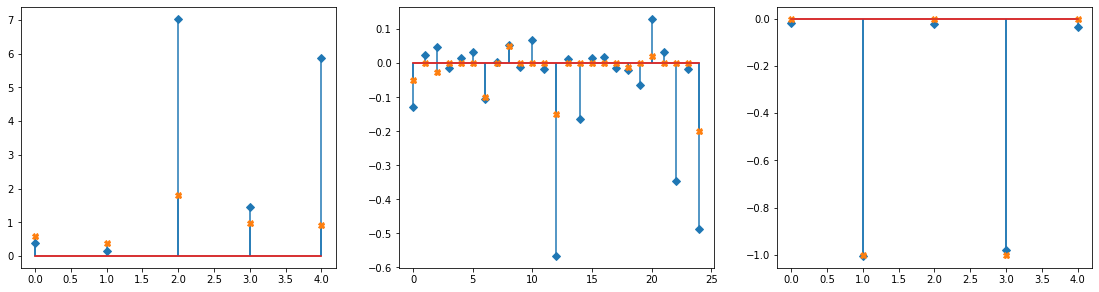

In [5]:
# Five species, single time course including a perturbation
## SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct perturbation matrix
epsilon = np.array([0, -1, 0 , -1, 0])

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu,
                     epsilon=epsilon)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

# perturbation
tp = 2

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, 
                                               sy0=np.hstack((init_species, init_metabolites)),
                                               tp=tp)


# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
# plot_gMLV(yobs, sobs, times)

## PERFORM REGRESSION
# time dependent perturbation
u = (times >= 2) & (times < 3) 
u = u.astype(int)
print(u)

# linearise
X, F = linearize_time_course_16S_u(yobs, times, u)
print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

# get the best lambda/alpha values on a grid via cross validation
a0, a1, a2 = fit_alpha_Ridge2(X, F, nsp=num_species, n_a0=10, n_a1=10, n_a2=10)

# do final fit
mu_h, M_h, e_h = do_final_fit_Ridge2(X, F, num_species, a0, a1, a2)

predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h,
                     epsilon=e_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times,
                                                sy0=np.hstack((init_species, init_metabolites)),
                                                tp=tp)

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params_p(mu_h, mu, M_h, M, e_h, e=np.array([0, -1, 0 , -1, 0]))



## Simulate some time course data and metabolites
This model assumes metabolite production is associated with abundance:  dS/dt = alpha X <br>
Note that this model needs rethinking as it cannot handle negative productivities <br>
In this simple example we don't need to infer the time course. We just linearize and estimate the elements of alpha with Lasso<br>
Number of metabolites is 6 here

number of species: 5
specific growth rates: [0.52036877 0.39479037 0.75068473 1.96689382 1.77935209]
interaction matrix: 
[[-0.05  0.    0.    0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.    0.    0.    0.   -0.2 ]]
metabolite production: 
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
minimum found: a/error: 1.2742749857031335 1.4346802615226952
min + se rule: a/error: 3.79269019073225 1.4516878318848125


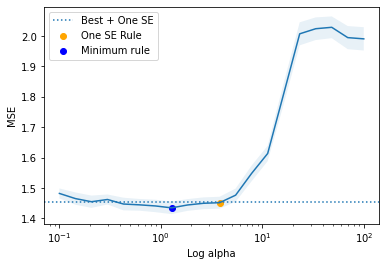


inferred params:
A_hat/A:
[[-0.   -0.   -0.   -0.   -0.  ]
 [ 0.86 -0.    0.   -0.    0.01]
 [-0.    0.   -0.    0.   -0.  ]
 [-0.    0.   -0.    0.   -0.  ]
 [-0.32  0.   -0.    0.   -0.  ]
 [ 0.   -0.    0.   -0.    0.  ]]

 [[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0. ]]


<StemContainer object of 3 artists>

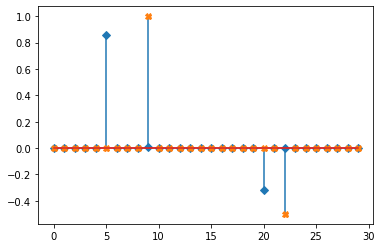

In [6]:
# Simulate some microbiota and metabolites
# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 6

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
# M[0,2] = -0.025
M[1, 3] = 0.05
# M[4,0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct metabolite production matrix
alpha = np.zeros((num_metabolites, num_species))
alpha[1, 4] = 1
alpha[4, 2] = -0.5

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu,
                     beta=alpha)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, _, _, _ = simulator.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

## PERFORM REGRESSION
# Linearize this problem
X, S = linearise_time_course_metabolites(sobs, yobs, times)

# get the best lambda/alpha value on a grid via cross validation
a_min, a_se = fit_alpha_lasso(X, S, n_a=20)
model = Lasso(fit_intercept=False, max_iter=10000, alpha=a_min)

# just fit based on plot
#gMLV_ML.plot_alpha_lasso(X, S, n_a=20)
#model = Lasso(fit_intercept=False, max_iter=10000, alpha=2)

model.fit(X, S)
alpha_h = model.coef_
#print("alpha_h:",alpha_h.shape)

print("\ninferred params:")
print("A_hat/A:")
print(np.round(np.array(alpha_h),decimals=2))
print("\n",np.array(alpha) )

# plot the params
# You can see Lasso does a pretty good job at picking out the metabolite, microbiota interactions
plt.figure()
plt.stem( np.arange(0, num_metabolites * num_species), np.array(alpha_h).flatten(), markerfmt="D" )
plt.stem( np.arange(0, num_metabolites * num_species), np.array(alpha).flatten(), markerfmt="X" )